# Evaluation of RCMs in terms of icclim indicators

In [1]:
## Tested using the following loaded modules
## module use /g/data/access/ngm/modules
## module load analysis3/21.10
import os, sys
workdir = "/g/data/xv83/users/bxn599/ACS/evaluation/"
os.chdir(workdir)
sys.path.append("./lib")
import lib_spatial
import lib_standards
import glob
import xarray as xr
import numpy as np
from scipy.stats import ttest_ind
from datetime import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import importlib
importlib.reload(lib_standards)
importlib.reload(lib_spatial)
import warnings
warnings.filterwarnings('ignore')



font = {'size'   : 2}
mpl.rc('font', **font)

## Configurations

In [2]:
DATA_LOCATIONS = {
    'AGCD': "/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/indices/AUS-r005/none/BOM-AGCD/historical/none/none/none/climdex",
    'BARPA-R:ERA5': "/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/indices/AUS-15/BOM/ECMWF-ERA5/evaluation/none/BOM-BARPA-R/v1/climdex",
    'ERA5': "/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/indices/AUS-25/none/ECMWF-ERA5/historical/none/none/none/climdex",
    'CCAM:ERA5': "/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/indices/AUS-10/CSIRO/ECMWF-ERA5/evaluation/none/CSIRO-CCAM-2203/v1/climdex",
}
# Frequency of icclim indicator
FREQ = 'month'
# Data sources to consider here
SOURCES = ['BARPA-R:ERA5', 'CCAM:ERA5', 'AGCD', 'ERA5']
# Grid to used as the reference grid to compute difference metrics
REFERENCE_GRID = 'AGCD'
# "Truth" for compute difference metrics
REFERENCE = 'AGCD'
# Region of interest, as per defined in lib_standards.DOMAINS
REGION = 'Australia'  
# Period of interest, as per defined in lib_standards.PERIODS
PERIOD = 'HISTORICAL_WHOLE' 
# Individual subregions to compute metrics
SUBREGIONS = lib_spatial.get_nrm_names()
# Difference metrics, as per defined in lib_standards.compute_score()
# METRICS = ['RMSE', 'Additive_Bias', 'Multiplicative_Bias', 'Correlation', 'Additive_Bias:DJF', 'Additive_Bias:JJA', 'Correlation:ClimMon']
# METRICS = ['Additive_Bias:DJF', 'Additive_Bias:JJA', 'Correlation:ClimMonth']
# Two periods for compute change as per defined in lib_standards.PERIODS
EARLYPERIOD = "HISTORICAL_EARLY"
LATEPERIOD = "HISTORICAL_LATE" 
# Season of interest, as per defined in lib_standards.SEASONS
# default season, unless specified otherwise in the METRICS
SEASON = 'all'
# icclim indicators to consider here
#INDEXES = ['TX', 'SU', 'TXx', 'TXn',
#           'TN', 'TR', 'TNx', 'FD', 'TNn',
#           'PRCPTOT', 'RR1', 'RR', 'R10mm', 'R20mm', 'RX1day', 'RX5day']
INDEXES = ['SU', 'TXx', 'TXn',
           'TR', 'TNx', 'TNn',
           'RR1', 'R10mm', 'RX1day']
UNITS = {'SU': "Days",
         'TR': "Nights",
         'RR1': "Days", 
         'TXx': 'K', 
         'TXn': 'K',
         'TNx': 'K', 
         'TNn': 'K',
         'TX': 'K',
         'TN': 'K',
         'PRCPTOT':'mm/mon',
         'R10mm': 'Days',
         'RX1day': 'mm',
         'SDII':'mm',
         'R75pTOT':'%'}
INDICES_LONG = {'SU':'Summer Days','TXx':"Max Daily Max", 'TXn':"Min Daily Max",
           'TR':"Tropical Nights", 'TNx':"Max Daily Min", 'TNn':"Min Daily Min",
                'TX':'Mean Daily Max','TN':'Mean Daily Min','PRCPTOT':'Total Precipitation',
           'RR1':"Rain Days", 'R10mm':"Heavy Rain Days", 'RX1day':"Max Daily Rainfall",
                'R75pTOT': 'Precipitation fraction due to very wet days','SDII':'Average precipitation \n during Wet Days'}
# SU, TXx, TXn, TR, TNx, TNn
# R10mm, RX1day, RR1 or RR?

In [3]:
lib_standards.PERIODS = {"HISTORICAL_WHOLE": ('1985-01-01', '2014-12-31'),
           "HISTORICAL_EARLY": ('1980-01-01', '1999-12-31'),
           "HISTORICAL_LATE": ('2000-01-01', '2020-01-01'),
           "FUTURE_NEAR": ('2015-01-01', '2044-12-31'),
           "FUTURE_MID": ('2035-01-01', '2064-12-31'),
           "FUTURE_FAR": ('2070-01-01', '2099-12-31')}

In [4]:
def prepare_data(index, sources=SOURCES, freq=FREQ, 
                 region=REGION, period=PERIOD, reference_grid=REFERENCE_GRID, season=SEASON,
                 apply_agcd_data_mask=False):
    """
    Reads in the icclim data and regrid to the reference grid.
    """
    # Load the data sources
    ds = {}
    for s in sources:
        print("Reading the data {:}".format(s))
        fs = glob.glob(os.path.join(DATA_LOCATIONS[s], index, "{index}_*_{freq}_*.nc".format(index=index, freq=freq)))
        ds[s] = xr.open_dataset(fs[0])
        ds[s] = lib_standards.standardise_data(ds[s], region=region, period=period, season=season, compute=True)
        
    # Regrid to the REFERENCE_GRID
    ds_regrid = {}
    for s in sources:
        print("Regridding the data {:} to reference grid of {:}".format(s, reference_grid))
        #ds_regrid[s] = lib_spatial.add_region_land_mask(ds[s], region)
        ds_regrid[s] = ds[s]
        
        #print("[0] {:} -> {:}".format(s, ds_regrid[s]['SU'].min()))
        if s == reference_grid:
            ds_regrid[s] = ds_regrid[s].compute()
        else:
            ds_regrid[s] = lib_standards.regrid(ds_regrid[s], ds[reference_grid]).compute()
        #print("[1] {:} -> {:}".format(s, ds_regrid[s]['SU'].min()))
        
        ds_regrid[s] = lib_spatial.apply_region_mask(ds_regrid[s], region)
        #print("[2] {:} -> {:}".format(s, ds_regrid[s]['SU'].min()))
        if apply_agcd_data_mask:
            ds_regrid[s] = lib_spatial.apply_agcd_data_mask(ds_regrid[s])
            #print("[3] {:} -> {:}".format(s, ds_regrid[s]['SU'].min()))
            
    return ds_regrid
                                                                 
def compute_difference_metrics(index, metric, ds, subregions=SUBREGIONS, reference=REFERENCE, aggregator='mean', dim='time'):
    """
    Computes the difference metrics for all the data (assumed already regridded to a common 
    reference grid), for each subregions.
    """
    scorecards = {}
    for source in ds.keys():
        # For each data source
        if source == reference:
            continue

        scorecards[source] = {}
                 
        # spatial correlations are slightly different
        if (dim == ('lat','lon') or dim == ('lon','lat')) and (metric=='Correlation'):
            for subregion in subregions:
                mean_source = lib_spatial.apply_region_mask(ds[source][index], subregion)
                mean_reference = lib_spatial.apply_region_mask(ds[reference][index], subregion)
                # Compute the difference metric against the reference data over the whole domain
                score = xr.corr(mean_source,mean_reference)
                scorecards[source][subregion] = float(score)
        else:
            # Compute the difference metric against the reference data over the whole domain
            score = lib_standards.compute_score(ds[reference][index], ds[source][index], metric, dims=dim)
                       
            # Aggregate the metric values over subregions
            for subregion in subregions:
                mean_score = lib_spatial.region_aggregation(score, aggregator, subregion)
                scorecards[source][subregion] = float(mean_score)
                       
    return scorecards

In [5]:
def annual_change_sig(index, ds, subregions=SUBREGIONS, 
                          reference=REFERENCE, aggregator='mean', 
                          earlyperiod=EARLYPERIOD, lateperiod=LATEPERIOD):
    """
    Computes the change metrics for all the data (assumed already regridded to a common 
    reference grid), for each subregions.
    """
    sig = {}
    for source in ds.keys():
        # For each data source
        
        sig[source] = {}
        # Compute the change delta between two time periods of the timeseries
        #change = lib_standards.compute_change(ds[source][index], dims='time', earlyperiod=earlyperiod, lateperiod=lateperiod)
        
        # Aggregate the change values over subregions
        for subregion in subregions:
            regionmean = lib_spatial.region_aggregation(ds[source][index].groupby("time.year").mean(), aggregator, subregion)
            early = regionmean.sel(year=slice(1980,1999))#int(lib_standards.PERIODS[earlyperiod][0][:4]),int(lib_standards.PERIODS[earlyperiod][1][:4])))
            late = regionmean.sel(year=slice(2000,2019))#int(lib_standards.PERIODS[lateperiod][0][:4]),int(lib_standards.PERIODS[lateperiod][1][:4])))
            sig[source][subregion] = float(ttest_ind(early,late).pvalue)
                       
    return sig




In [6]:
def compute_change_metric(index, ds, subregions=SUBREGIONS, 
                          reference=REFERENCE, aggregator='mean', 
                          earlyperiod=EARLYPERIOD, lateperiod=LATEPERIOD):
    """
    Computes the change metrics for all the data (assumed already regridded to a common 
    reference grid), for each subregions.
    """
    changes = {}
    for source in ds.keys():
        # For each data source
        
        changes[source] = {}
        # Compute the change delta between two time periods of the timeseries
        change = lib_standards.compute_change(ds[source][index], dims='time', earlyperiod=earlyperiod, lateperiod=lateperiod)
        
        # Aggregate the change values over subregions
        for subregion in subregions:
            mean_change = lib_spatial.region_aggregation(change, aggregator, subregion)
            changes[source][subregion] = float(mean_change)
                       
    return changes

def apply_metric_condition(ds, index, metric, freq=FREQ):
    """
    Apply special conditions to the data, specified using the name "metric"
    """
    
    # check whether the metric has special conditions
    metric_condition = None
    if not ":" in metric:
        label = "{metric} for {index}({freq})".format(metric=metric, freq=freq, index=index)
        ds_target = ds
        dim = 'time'
        metric_name = metric
    else:
        metric_condition = metric.split(":")[1]
        metric_name = metric.split(":")[0]
        
        ds_target = {}
        if metric_condition in ['DJF', 'MAM', 'JJA', 'SON']:
            # Only use data for the selected seasons
            for s in ds.keys():
                ds_target[s] = ds[s].sel(time=ds[s].time.dt.month.isin(lib_standards.SEASONS[metric_condition]))
            label = "{metric} for {index}({metric_condition})".format(metric=metric_name, metric_condition=metric_condition, index=index)
            dim = 'time'
        elif metric_condition == 'ClimMon':
            # Convert to climatological monthly averages
            for s in ds.keys():
                ds_target[s] = ds[s].groupby("time.month").mean(dim="time")
            label = "{metric} for {index}(clim month mean)".format(metric=metric_name, index=index)
            dim = 'month'
        elif metric_condition == 'Annual':
            # Convert to annual averages
            for s in ds.keys():
                ds_target[s] = ds[s].groupby("time.year").mean(dim="time")
            label = "{metric} for {index}(annual mean)".format(metric=metric, index=index)
            dim = 'year'
        elif metric_condition == 'Spatial':
            # Convert to climatological mean
            for s in ds.keys():
                ds_target[s] = ds[s].mean(dim="time")
            label = "{metric} for {index}(spatial)".format(metric=metric, index=index)
            dim = ('lat','lon')
        else:
            assert False, "Undefined metric condition: {:}".format(metric_condition)
            
    return ds_target, metric_name, dim, label

def reorder_regions(olddict):
    """
    Reorder the region names in the dictionary
    """
    
    ordered_list = ['Southern Slopes', 'Murray Basin', 
                    'Southern and South Western Flatlands', 
                    'Central Slopes', 'East Coast', 'Rangelands', 
                    'Monsoonal North', 'Wet Tropics']
    newdict = {}
    for n in ordered_list:
        newdict[n] = olddict[n]
    
    return newdict

In [7]:
def compute_score_barchart(index, metrics):
    
    style = {'BARPA-R:ERA5':'fill','ERA5':'lines','CCAM:ERA5':'hatch'}
    
    #y_limits = {"Additive Bias": (-2.2,2.2),
    #        "Multiplicative Bias": (-0.2,0.2),
    #        "Correlation": (0.5,1.5)}
    
    metric_map = {}
        
    scorecards = {}
    
    # Prepare all the icclim data as per the setup in CONFIGURATIONS
    print("index = {:}".format(index))
    ds = prepare_data(index)
    
    for metric in metrics:
        #print(" --> {:}".format(metric))
        ds_target, metric_name, dim, clabel = apply_metric_condition(ds, index, metric)
        
        metric_name_proper = metric_name.replace("_"," ")
        if not metric_name_proper in metric_map.keys():
            metric_map[metric_name_proper] = [metric]
        else:
            metric_map[metric_name_proper].append(metric)
            
        # Compute difference metrics as per the setup in CONFIGURATIONS
        scorecards[metric] = compute_difference_metrics(index, metric_name, ds_target, dim=dim)
    
    #fig, ax = plt.subplots(figsize=(10,6))
    #x = 0
    #for met in scorecards.keys():
    #    if 'Additive_Bias' in met:
    #        for model in scorecards[met].keys():
    #            x = np.max(np.abs([scorecards[met][model][j] for j in scorecards[met][model]] + [x]))
    # 
    #y = np.ceil(2*x/(10**int(np.log10(x))))*(10**int(np.log10(x)))/2
    #y_limits['Additive Bias'] = (-y,y)
    
    # Reorder the region
    scorecards_ordered = {}
    for met in scorecards.keys():
        scorecards_ordered[met] = {}
        for model in scorecards[met].keys():
            scorecards_ordered[met][model] = reorder_regions(scorecards[met][model])
                
    #lib_standards.bar_plot(ax, scorecards_ordered, INDICES_LONG[index], metric_map, style, UNITS[index])
    
    return scorecards_ordered

def replot_score_barchart(index, metrics,scorecards, ax,tune,legend=True):
    
    style = {'BARPA-R:ERA5':'fill','ERA5':'lines','CCAM:ERA5':'hatch'}
    
    #y_limits = {"Additive Bias": (-2.2,2.2),
    #        "Multiplicative Bias": (-0.2,0.2),
    #        "Correlation": (0.5,1.5)}
    
    metric_map = {}
        
    #scorecards = {}
    
    # Prepare all the icclim data as per the setup in CONFIGURATIONS
    print("index = {:}".format(index))
    for metric in metrics:
        if not ":" in metric:
            metric_name = metric
        else:
            metric_name = metric.split(":")[0]    
        #print(" --> {:}".format(metric))
        #ds_target, metric_name, dim, clabel = apply_metric_condition(ds, index, metric)
        
        metric_name_proper = metric_name.replace("_"," ")
        if not metric_name_proper in metric_map.keys():
            metric_map[metric_name_proper] = [metric]
        else:
            metric_map[metric_name_proper].append(metric)
            
        # Compute difference metrics as per the setup in CONFIGURATIONS
        #scorecards[metric] = compute_difference_metrics(index, metric_name, ds_target, dim=dim)
    
    #fig, ax = plt.subplots(figsize=(10,6))
    #x = 0
    #for met in scorecards.keys():
    #    if 'Additive_Bias' in met:
    #        for model in scorecards[met].keys():
    #            x = np.max(np.abs([scorecards[met][model][j] for j in scorecards[met][model]] + [x]))
    # 
    #y = np.ceil(2*x/(10**int(np.log10(x))))*(10**int(np.log10(x)))/2
    #y_limits['Additive Bias'] = (-y,y)
    
    # Reorder the region
    #scorecards_ordered = {}
    #for met in scorecards.keys():
    #    scorecards_ordered[met] = {}
    #    for model in scorecards[met].keys():
    #        scorecards_ordered[met][model] = reorder_regions(scorecards[met][model])
                
    bars =  lib_standards.bar_plot(ax, scorecards, INDICES_LONG[index], metric_map, style, UNITS[index],tune=tune,legend=legend)
    
    return bars



## For the main paper: Repeat the temperature-related metrics but for specific months namely DJF and JJA

In [8]:
metrics = ['Additive_Bias:DJF', 'Additive_Bias:JJA', 'Multiplicative_Bias:Annual', 'Correlation:ClimMon', 'Correlation:Spatial']
indexes = ['SU', 'TXx', 'TXn',
           'TR', 'TNx', 'TNn']
indexes = ['TX','TN']

all_scorecards = {}
for index in indexes:
    all_scorecards[index] = compute_score_barchart(index, metrics)

index = TX
Reading the data BARPA-R:ERA5
Reading the data CCAM:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of AGCD
Regridding the data CCAM:ERA5 to reference grid of AGCD
Regridding the data AGCD to reference grid of AGCD
Regridding the data ERA5 to reference grid of AGCD
index = TN
Reading the data BARPA-R:ERA5
Reading the data CCAM:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of AGCD
Regridding the data CCAM:ERA5 to reference grid of AGCD
Regridding the data AGCD to reference grid of AGCD
Regridding the data ERA5 to reference grid of AGCD


## For the main paper: Repeat the rainfall-related metrics but for specific months namely DJF and JJA

In [9]:
metrics = ['Additive_Bias:DJF', 'Additive_Bias:JJA', 'Multiplicative_Bias:Annual', 'Correlation:ClimMon', 'Correlation:Spatial']
indexes = ['RR1', 'R10mm', 'RX1day','PRCPTOT','SDII']


for i,index in enumerate(indexes):
    if index not in all_scorecards:
        all_scorecards[index] = compute_score_barchart(index, metrics)

index = RR1
Reading the data BARPA-R:ERA5
Reading the data CCAM:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of AGCD
Regridding the data CCAM:ERA5 to reference grid of AGCD
Regridding the data AGCD to reference grid of AGCD
Regridding the data ERA5 to reference grid of AGCD
index = R10mm
Reading the data BARPA-R:ERA5
Reading the data CCAM:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of AGCD
Regridding the data CCAM:ERA5 to reference grid of AGCD
Regridding the data AGCD to reference grid of AGCD
Regridding the data ERA5 to reference grid of AGCD
index = RX1day
Reading the data BARPA-R:ERA5
Reading the data CCAM:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of AGCD
Regridding the data CCAM:ERA5 to reference grid of AGCD
Regridding the data AGCD to reference grid of AGCD
Regridding the data ERA5 to reference grid of AGCD
index

index = TX


AssertionError: Not yet configured for more than 2 models

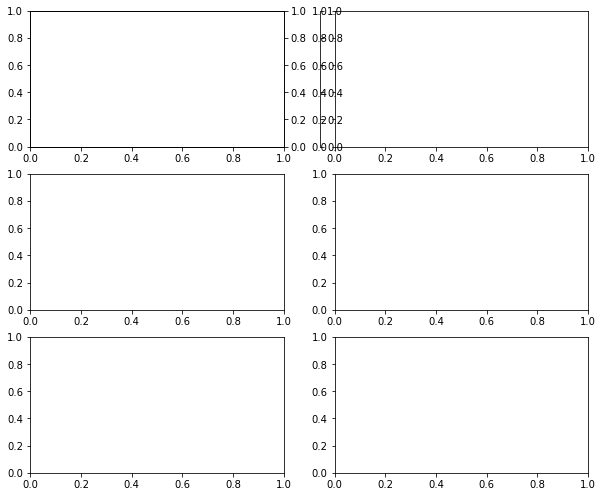

In [10]:
metrics = ['Additive_Bias:DJF', 'Additive_Bias:JJA', 'Stdev_Bias:Annual', 'Correlation:ClimMon', 'Correlation:Spatial']
indexes = ['SU', 'TR','TXx', 'TXn',
            'TNx', 'TNn']
indexes = ['TX','TN']

all_scorecards[index]['Stdev_Bias:Annual'] = all_scorecards[index]['Multiplicative_Bias:Annual']

import importlib
importlib.reload(lib_standards)
lib_standards.SHORTHANDS['Rangelands'] = 'Range- lands'
font = {'size'   : 8}
mpl.rc('font', **font)
fig,ax = plt.subplots(3,2,figsize=(10,8.5))
ax = ax.flatten()
for i,index in enumerate(indexes):
    all_scorecards[index]['Stdev_Bias:Annual'] = all_scorecards[index]['Multiplicative_Bias:Annual']
    bars = replot_score_barchart(index, metrics,all_scorecards[index], ax[i],tune=[7,5][i%2],legend = i==0)[0]
    if i%2==0:
        bars[1].set_ylabel('')
        bars[2].set_ylabel('')
    else:
        bars[0].set_ylabel('')

fig.tight_layout()
fig.savefig("icclim_T.png",dpi=300)
#fig.subplots_adjust(wspace=0.31)

In [ ]:
metrics = ['Additive_Bias:DJF', 'Additive_Bias:JJA', 'Stdev_Bias:Annual', 'Correlation:ClimMon', 'Correlation:Spatial']
indexes = ['RR1', 'R10mm', 'RX1day','SDII']
importlib.reload(lib_standards)
lib_standards.SHORTHANDS['Rangelands'] = 'Range- lands'

fig,ax = plt.subplots(2,2,figsize=(10,5.5))
ax = ax.flatten()
for i,index in enumerate(indexes):
    all_scorecards[index]['Stdev_Bias:Annual'] = all_scorecards[index]['Multiplicative_Bias:Annual']
    bars = replot_score_barchart(index, metrics,all_scorecards[index], ax[i],tune=[7,5][i%2],legend=(i==3))[0]
    if i%2==0:
        bars[1].set_ylabel('')
        bars[2].set_ylabel('')
    else:
        bars[0].set_ylabel('')

fig.tight_layout()
#fig.subplots_adjust(wspace=0.31)
fig.savefig("icclim_P.png",dpi=300)

## Repeat the temperature-related metrics but for specific months namely MAM and SON (Supplementary)

In [ ]:
metrics = ['Additive_Bias:MAM', 'Additive_Bias:SON']
indexes = ['SU', 'TXx', 'TXn',
           'TR', 'TNx', 'TNn']

all_scorecards = {}
for index in indexes:
    all_scorecards[index] = compute_score_barchart(index, metrics)

## Repeat the rainfall-related metrics but for specific months namely MAM and SON (Supplementary)

In [ ]:
metrics = ['Additive_Bias:MAM', 'Additive_Bias:SON']
indexes = ['RR1', 'R10mm', 'RX1day']

all_scorecards = {}
for index in indexes:
    all_scorecards[index] = compute_score_barchart(index, metrics)

## For the main paper: Compare temporal change in temperature-related indicator values using all the months

In [ ]:

from matplotlib import cm
def annotate(pcolormesh,data,sig,string):
    """
    adds text to pcolormesh. Colour of text is black or white depending on lightness of underlying figure
    Parameters
    ----------
    pcolormesh: matplotlib.pyplot.pcolormesh 
        plot object to extract colours from
    data: numpy.array 
        2D data values for text (should be array used to create pcolormesh)
    string: char
        string format for text
    """
    amp = (np.array(cm.get_cmap(pcolormesh.cmap)(pcolormesh.norm(data)))**2).mean(axis=2)
    print(amp.shape,data.shape)
    for i in range(data.shape[1]):
        for j in range(data.shape[0]):
            if sig[j][i]:
                plt.text(i,j,string%data[j,i],color=['k','w'][int(amp[j,i]<0.4)],ha='center',va='center')
    cm.get_cmap('BrBG')(1)

In [ ]:
INDEXES = ['TX','TN', 'SU','TN', 'TXx', 'TXn', 'TNx', 'TNn']
sig_ordered = {}
changes_ordered = {}

for j, index in enumerate(INDEXES):
    print("Doing index {:}".format(index))
    # Prepare all the icclim data as per the setup in CONFIGURATIONS
    ds = prepare_data(index)
    for season in ['all']:
        ds_seas = {}
        for source in ds.keys():
            ds_seas[source] = ds[source].sel(time=ds[source].time.dt.month.isin(lib_standards.SEASONS[season]))
        # Compute difference metrics as per the setup in CONFIGURATIONS
        changes = compute_change_metric(index, ds_seas)
        sig = annual_change_sig(index,ds_seas)
        sig_ordered[index] = {}
        changes_ordered[index] = {}
        for m in changes.keys():
            changes_ordered[index][m] = reorder_regions(changes[m])
            sig_ordered[index][m] = reorder_regions(sig[m])


In [ ]:
INDEXES = ['TX','TN', 'SU','TN', 'TXx', 'TXn', 'TNx', 'TNn']
cmap_variable = 'temp'
cmap_class = 'hot_diff'
fig_xy = (2, len(INDEXES)//2)
fig = plt.figure(figsize=(12, 10))

for j, index in enumerate(INDEXES):
    print("Doing index {:}".format(index))
    # Prepare all the icclim data as per the setup in CONFIGURATIONS

    for season in ['all']:
        ax = plt.subplot(fig_xy[0], fig_xy[1], j+1)

        add_xticklabels = False
        add_yticklabels = False        
        if j in [0,4]:
            add_yticklabels = True
        if j>3:
            add_xticklabels = True            
        tp = lib_standards.table_plot(ax, changes_ordered[index], 
                clabel="Delta for {index}({season})".format(index=index, season=season),
                add_xticklabels=add_xticklabels,
                add_yticklabels=add_yticklabels,
                xrotation=90, shrink=0.8,
                cmap_variable=cmap_variable, cmap_class=cmap_class)
        
        c = np.array([[changes_ordered[index][key1][key2] for key2 in changes_ordered[index][key1]] for key1 in changes_ordered[index]]).T
        s = np.array([[sig_ordered[index][key1][key2] for key2 in sig_ordered[index][key1]] for key1 in sig_ordered[index]]).T
        annotate(tp,c,s<0.05,'%0.1f')
        plt.title(INDICES_LONG[index])
        
    #plt.subplots_adjust(wspace=0.4)

#plt.tight_layout()
plt.savefig("trend_T.png",dpi=300)

## Compare temporal change in rainfall-related indicator values using all the months

In [ ]:
INDEXES = ['PRCPTOT','RR1', 'R10mm', 'RX1day', 'SDII'][:]

for j, index in enumerate(INDEXES):
    print("Doing index {:}".format(index))
    # Prepare all the icclim data as per the setup in CONFIGURATIONS
    ds = prepare_data(index)
    for season in ['all']:
        ds_seas = {}
        for source in ds.keys():
            ds_seas[source] = ds[source].sel(time=ds[source].time.dt.month.isin(lib_standards.SEASONS[season]))
        # Compute difference metrics as per the setup in CONFIGURATIONS
        changes = compute_change_metric(index, ds_seas)
        sig = annual_change_sig(index,ds_seas)
        sig_ordered[index] = {}
        changes_ordered[index] = {}
        for m in changes.keys():
            changes_ordered[index][m] = reorder_regions(changes[m])
            sig_ordered[index][m] = reorder_regions(sig[m])


In [ ]:
INDEXES = ['PRCPTOT','RR1', 'R10mm', 'RX1day', 'SDII'][:]

cmap_variable = 'precip'
cmap_class = 'wet_diff'
fig_xy = (1, len(INDEXES))
fig = plt.figure(figsize=(15, 5))

for j, index in enumerate(INDEXES):
    print("Doing index {:}".format(index))
    # Prepare all the icclim data as per the setup in CONFIGURATIONS

    for season in ['all']:
        ax = plt.subplot(fig_xy[0], fig_xy[1], j+1)

        add_xticklabels = False
        add_yticklabels = False        
        if j == 0:
            add_yticklabels = True
        add_xticklabels = True            
        tp = lib_standards.table_plot(ax, changes_ordered[index], 
                clabel="Delta for {index}({season})".format(index=index, season=season),
                add_xticklabels=add_xticklabels,
                add_yticklabels=add_yticklabels,
                xrotation=90, shrink=0.8,
                cmap_variable=cmap_variable, cmap_class=cmap_class)
        
        c = np.array([[changes_ordered[index][key1][key2] for key2 in changes_ordered[index][key1]] for key1 in changes_ordered[index]]).T
        s = np.array([[sig_ordered[index][key1][key2] for key2 in sig_ordered[index][key1]] for key1 in sig_ordered[index]]).T
        annotate(tp,c,s<0.05,'%0.1f')
        plt.title(INDICES_LONG[index])
        
    plt.subplots_adjust(wspace=0.5)

#plt.tight_layout()
plt.savefig("trend_P.png",dpi=300)

## Compare temporal change in temperature-related indicator values for different seasons (Supplementary)

In [ ]:
INDEXES = ['SU', 'TXx', 'TXn',
           'TR', 'TNx', 'TNn']
cmap_variable = 'temp'
cmap_class = 'hot_diff'
importlib.reload(lib_standards)
    
for j, index in enumerate(INDEXES):
    print("Doing index {:}".format(index))
    # Prepare all the icclim data as per the setup in CONFIGURATIONS
    ds = prepare_data(index)

    fig_xy = (1, 4)
    fig = plt.figure(figsize=(15, 5))

    for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
        ax = plt.subplot(fig_xy[0], fig_xy[1], i+1)

        ds_seas = {}
        for source in ds.keys():
            ds_seas[source] = ds[source].sel(time=ds[source].time.dt.month.isin(lib_standards.SEASONS[season]))
    
        # Compute difference metrics as per the setup in CONFIGURATIONS
        changes = compute_change_metric(index, ds_seas)

        add_xticklabels = False
        add_yticklabels = False
        
        if i == 0:
            add_yticklabels = True
        if j == len(INDEXES)-1:
            add_xticklabels = True
        
        add_xticklabels = True
        
        changes_ordered = {}
        for m in changes.keys():
            changes_ordered[m] = reorder_regions(changes[m])
            
        lib_standards.table_plot(ax, changes_ordered, 
                clabel="Delta for {index}({season})".format(index=index, season=season),
                add_xticklabels=add_xticklabels,
                add_yticklabels=add_yticklabels,
                xrotation=90, shrink=0.8,
                cmap_variable=cmap_variable, cmap_class=cmap_class)
        
    plt.subplots_adjust(wspace=0.4)


## Compare temporal change in rainfall-related indicator values for different seasons (Supplementary)

In [ ]:
INDEXES = ['RR1', 'R10mm', 'RX1day']
cmap_variable = 'precip'
cmap_class = 'wet_diff'
importlib.reload(lib_standards)
    
for j, index in enumerate(INDEXES):
    print("Doing index {:}".format(index))
    # Prepare all the icclim data as per the setup in CONFIGURATIONS
    ds = prepare_data(index, apply_agcd_data_mask=True)

    fig_xy = (1, 4)
    fig = plt.figure(figsize=(15, 5))

    for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
        ax = plt.subplot(fig_xy[0], fig_xy[1], i+1)

        ds_seas = {}
        for source in ds.keys():
            ds_seas[source] = ds[source].sel(time=ds[source].time.dt.month.isin(lib_standards.SEASONS[season]))
    
        # Compute difference metrics as per the setup in CONFIGURATIONS
        changes = compute_change_metric(index, ds_seas)

        add_xticklabels = False
        add_yticklabels = False
        
        if i == 0:
            add_yticklabels = True
        if j == len(INDEXES)-1:
            add_xticklabels = True
        
        add_xticklabels = True
        
        changes_ordered = {}
        for m in changes.keys():
            changes_ordered[m] = reorder_regions(changes[m])
            
        lib_standards.table_plot(ax, changes_ordered, 
                clabel="Delta for {index}({season})".format(index=index, season=season),
                add_xticklabels=add_xticklabels,
                add_yticklabels=add_yticklabels,
                xrotation=90, shrink=0.8,
                cmap_variable=cmap_variable, cmap_class=cmap_class)
        
    plt.subplots_adjust(wspace=0.4)

# Check icclim data files

In [ ]:
indir = '/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/indices/AUS-15/BOM/ECMWF-ERA5/evaluation/r1i1p1f1/BOM-BARPA-R/v1/climdex'
files = glob.glob(os.path.join(indir, '*', '*_month_*.nc'))

In [ ]:
for file in files:
    ds = xr.open_dataset(file)
    variable = [v for v in list(ds.keys()) if not 'time' in v][0]
    vmin = ds.min().compute()[variable].values
    vmax = ds.max().compute()[variable].values
    nnan = ds.isnull().sum().compute()[variable].values
    print("{:}, vmin={:}, vmax={:}, nnan={:}".format(variable, vmin, vmax, nnan))